In [1]:
import pandas as pd
import numpy as np
from PIL import Image

def load_images(dataset_name, load_labels = True):
    index = pd.read_csv(f"{dataset_name}.txt")
    files = [f"{dataset_name}/{filename}" for filename in index.iloc[:, 0]]
    
    if load_labels:
        labels = np.array(index.iloc[:, 1], dtype=np.uint8)
        labels = np.reshape(labels, (-1))
    else:
        labels = None
    
    images = [np.array(Image.open(filename), dtype=np.uint8) for filename in files]
    images = [np.reshape(img, (-1)) for img in images]
    images = np.array(images)
    
    return images, labels

def images_to_numpy(dataset_name, load_labels = True):
    images, labels = load_images(dataset_name, load_labels)
    np.save(f"{dataset_name}.npy", images)
    if load_labels:
        np.save(f"{dataset_name}_labels.npy", labels)
    
def load_dataset(dataset_name, load_labels = True):
    return np.load(f"{dataset_name}.npy"), np.load(f"{dataset_name}_labels.npy")

In [2]:
images_to_numpy('train')
images_to_numpy('validation')
images_to_numpy('test', load_labels = False)

In [44]:
train_set, train_labels = load_dataset('train')
validation_set, validation_labels = load_dataset('validation')
test_set = np.load("test.npy")

print (train_set.shape, train_labels.shape, train_set.dtype, train_labels.dtype)
print (test_set.shape, test_set.dtype)

(30000, 1024) (30000,) uint8 uint8
(4999, 1024) uint8


[0 1 2 3 4 5 6 7 8]
[3325 3325 3242 3351 3436 3307 3432 3234 3348]
[0.11083333 0.11083333 0.10806667 0.1117     0.11453333 0.11023333
 0.1144     0.1078     0.1116    ]
[570 527 533 578 554 561 580 520 576]
[0.1140228  0.10542108 0.10662132 0.11562312 0.11082216 0.11222244
 0.1160232  0.1040208  0.11522304]
(30000,)
131.82742047526042 86.66560654611982 127.5
131.82742047526042 46.56408721937065 127.5


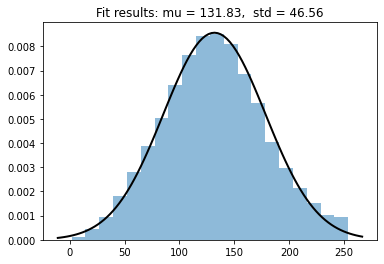

38.69924603651913 224.95559491400172


In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm

print (np.unique(train_labels))
print (np.bincount(train_labels))
print (np.bincount(train_labels)/len(train_labels))
print (np.bincount(validation_labels))
print (np.bincount(validation_labels)/len(validation_labels))

means = np.mean(train_set, axis=1)
print (means.shape)
print (np.mean(train_set), np.std(train_set), 255/2)
print (np.mean(means), np.std(means), 255/2)

mu, std = norm.fit(means)
plt.hist(means, bins=20, density=True, alpha=0.5)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()

print (mu - 2*std, mu + 2*std)

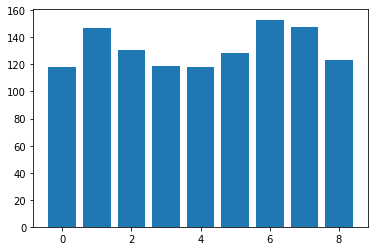

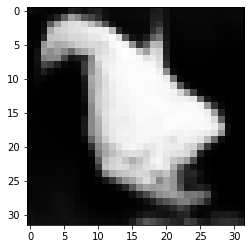

,mean,label,index
0,184.920898,0,0
1,172.026367,0,1
2,115.020508,5,2
3,78.558594,8,3
4,104.521484,6,4


In [7]:
df = pd.DataFrame({'mean': means, 'label': train_labels, 'index': np.arange(0, len(train_labels))})
df = df.astype({'mean': 'float64', 'label': 'uint8', 'index': 'uint32'})

res = df.groupby(['label']).mean()

plt.bar(np.arange(0, 9), res['mean'])
plt.show()
plt.imshow(train_set[9].reshape(32, 32), cmap='gray')
plt.show()

df.head()

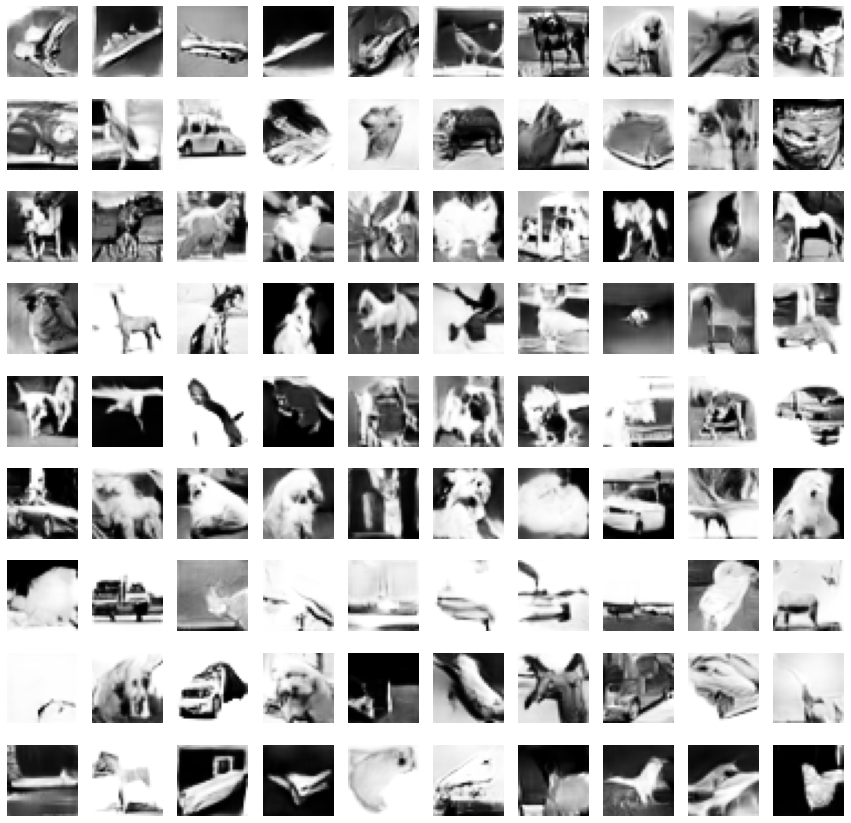

In [233]:
def show_sample(imgs, df, categs, samples):
    f, axarr = plt.subplots(categs,samples, figsize=(15, 15))
    
    cnt = 0
    cls = 0
    for index, row in df.groupby('label', as_index=False).sample(samples).iterrows():
        assert int(row['label']) == cls
        ax = axarr[int(row['label']),cnt]
        
        img = imgs[int(row['index'])] 
        ax.imshow(img.reshape(32, 32), cmap='gray')
        ax.axis("off")
        cnt += 1
        if cnt == samples:
            cnt = 0
            cls += 1
            
    plt.show()
        
show_sample(train_set, df, 9, 10)

def white_background(X):
    X = [255-x if np.mean(x) < 255/2 else x for x in X]
    X = np.array(X, dtype=np.uint8)
    return X

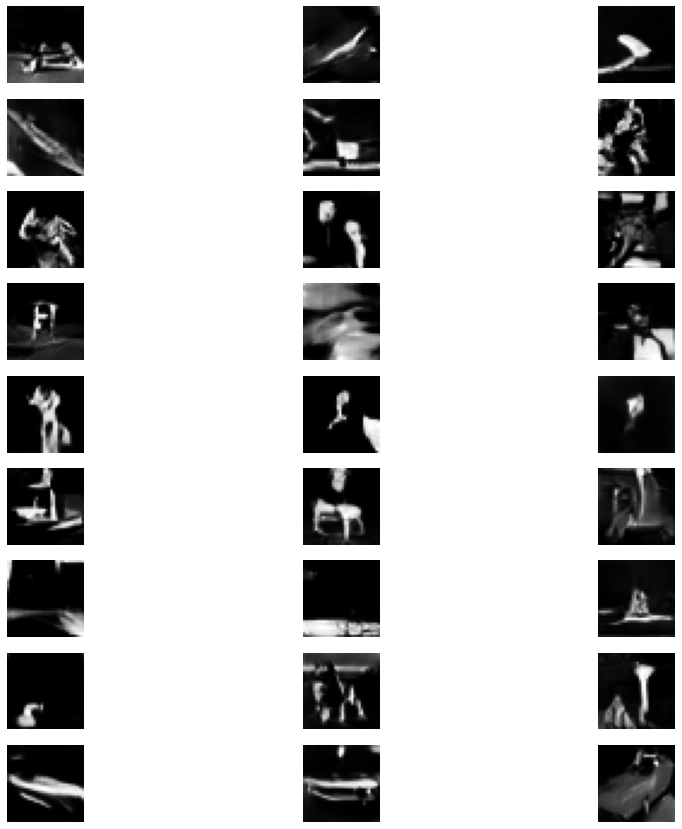

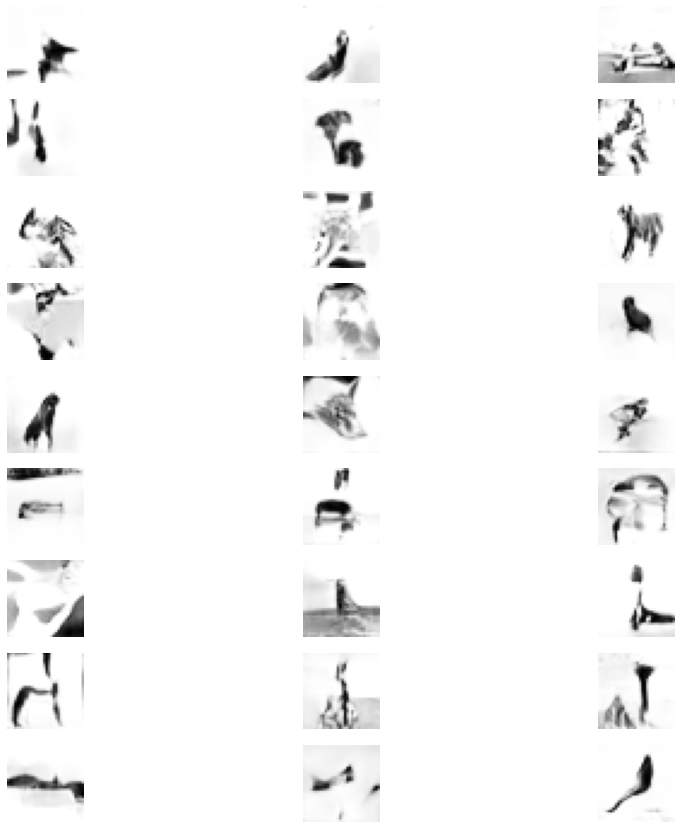

In [234]:
show_sample(train_set, df[df["mean"] < 40], 9, 3)
show_sample(white_background(train_set), df[df["mean"] < 40], 9, 3)

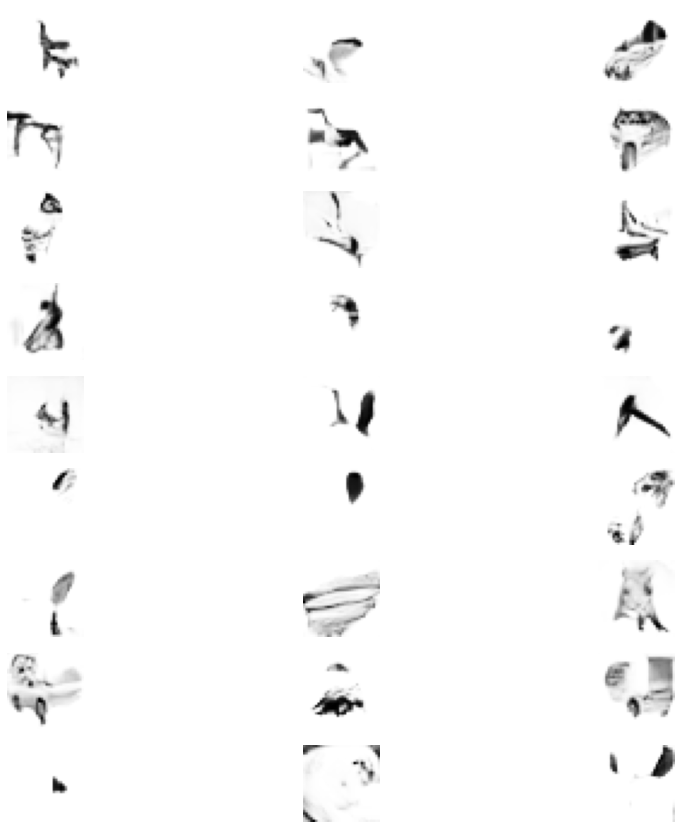

In [196]:
show_sample(train_set, df[df["mean"] > 223], 9, 3)

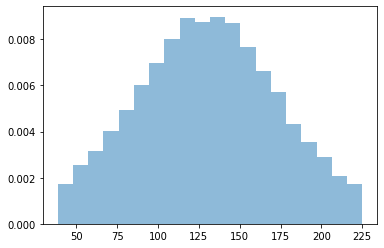

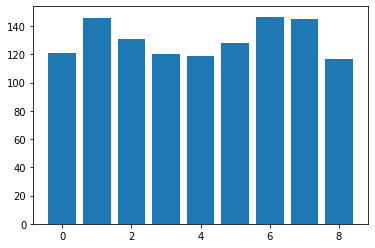

(28584, 1024) (28584,)


In [8]:
df_clean = df[(mu - 2 * std <= df['mean']) & (df['mean'] <= mu + 2 * std)]
plt.hist(df_clean['mean'], bins=20, density=True, alpha=0.5)
plt.show()

res = df_clean.groupby(['label']).mean()
plt.bar(np.arange(0, 9), res['mean'])
plt.show()

clean_train_set = train_set[df_clean["index"]]
clean_train_labels = train_labels[df_clean["index"]]

print (clean_train_set.shape, clean_train_labels.shape)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin

from sklearn.svm import SVC # 70% (10 minute)
from sklearn.neighbors import KNeighborsClassifier # 40%
from sklearn.linear_model import LogisticRegression, Perceptron # 30, 40%
from sklearn.tree import DecisionTreeClassifier # 40%
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # 60, 66% (GBC dureaza prea mult 1h)

class SimpleNormalizer:
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X / 255

    def __str__(self):
        return 'SimpleNormalizer()'
    
    def __repr__(self):
        return self.__str__()
    
processing_grid = {
    'scale': [SimpleNormalizer()],
    'train': [KNeighborsClassifier(), Perceptron(), RandomForestClassifier(), SVC()],
}
steps = ['scale', 'train']

In [213]:
from itertools import product
from sklearn.model_selection import cross_val_score

def create_pipelines():
    combs = product(*[processing_grid[k] for k in steps])
    args = [zip(steps, comb) for comb in combs]
    pipelines = [Pipeline(list(arg)) for arg in args]
    return pipelines
    
pipelines = create_pipelines()

#X, y = train_set, train_labels
X, y = clean_train_set, clean_train_labels

for pipeline in pipelines:
    print (f"{pipeline}")
    score = cross_val_score(pipeline, X, y, cv=3, scoring='accuracy', n_jobs=-1, verbose=5)
    print (f"{pipeline} finished with score {score}")
    print ()

Pipeline(steps=[('scale', SimpleNormalizer()),
                ('train', KNeighborsClassifier())])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.2min finished


Pipeline(steps=[('scale', SimpleNormalizer()),
                ('train', KNeighborsClassifier())]) finished with score [0.45665407 0.44489924 0.43860202]

Pipeline(steps=[('scale', SimpleNormalizer()), ('train', Perceptron())])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s finished


Pipeline(steps=[('scale', SimpleNormalizer()), ('train', Perceptron())]) finished with score [0.50829135 0.46064232 0.39441646]

Pipeline(steps=[('scale', SimpleNormalizer()),
                ('train', RandomForestClassifier())])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.2s finished


Pipeline(steps=[('scale', SimpleNormalizer()),
                ('train', RandomForestClassifier())]) finished with score [0.60453401 0.59907641 0.59225441]

Pipeline(steps=[('scale', SimpleNormalizer()), ('train', SVC())])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.3min finished


Pipeline(steps=[('scale', SimpleNormalizer()), ('train', SVC())]) finished with score [0.72365659 0.71557515 0.72082284]



In [69]:
pipeline = Pipeline(list(zip(steps, [
    SimpleNormalizer(),
    SVC(),
])))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

pipeline.fit(X, y)
predictions = pipeline.predict(validation_set)
accuracy_score(validation_labels, predictions)

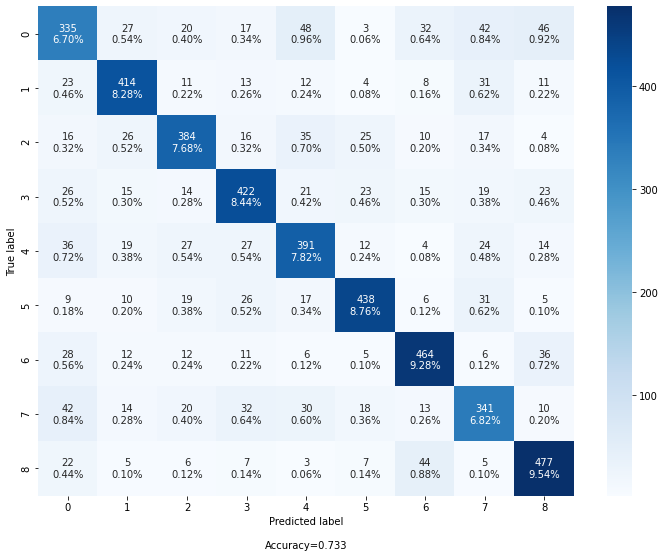

In [216]:
import confusion_matrix_plot as cmp
# Reference: https://github.com/DTrimarchi10/confusion_matrix

matrix = confusion_matrix(validation_labels, predictions)
cmp.make_confusion_matrix(matrix, figsize=(12, 9))

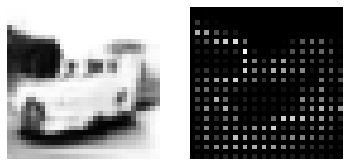

(2048,)

In [91]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

image = train_set[10000].reshape(32, 32)
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(2, 2),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
plt.show()

fd.shape

In [93]:
def hog_it(image):
    return hog(image, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1))

train_set_hog = np.array([hog_it(x.reshape(32, 32)) for x in train_set])

In [66]:
validation_set_hog = np.array([hog_it(x.reshape(32, 32)) for x in validation_set])

In [95]:
train_set_hog.shape

(30000, 512)

In [ ]:
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(list(zip(steps, [
    KNeighborsClassifier(),
])))

print (pipeline)
cross_val_score(pipeline, train_set_hog, train_labels, cv=3, scoring='accuracy', n_jobs=3, verbose=10)

Pipeline(steps=[('scale', KNeighborsClassifier())])


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

pipeline = Pipeline(list(zip(steps, [
    SimpleNormalizer(),
    SVC(),
])))

grid = [
    {
        'train__kernel': ['linear'],
        'train__random_state': [42],
    },
    {
        'train__kernel': ['poly'],
        'train__degree': [3, 5, 10],
        'train__gamma': ['auto', 'scale'],
        'train__random_state': [42],
    },
    {
        'train__kernel': ['rbf'],
        'train__gamma': ['auto', 'scale'],
        'train__random_state': [42],
    },
]

cv = GridSearchCV(pipeline, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=10)

In [30]:
print(cv.best_params_, cv.best_score_)

{'train__gamma': 'scale', 'train__kernel': 'rbf', 'train__random_state': 42} 0.7310000000000001


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(validation_labels, cv.best_estimator_.predict(validation_set))

0.7349469893978796

In [26]:
import pickle
with open('svm_grid.model', 'wb') as f:
    pickle.dump(cv, f)

In [32]:
grid = [
    {
        'train__C': [0.25, 0.5, 500, 1000],
        'train__kernel': ['rbf'],
        'train__gamma': ['scale'],
        'train__random_state': [42],
    },
]

cv_rbf = GridSearchCV(pipeline, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=10)

In [33]:
cv_rbf.fit(train_set, train_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', SimpleNormalizer()),
                                       ('train', SVC())]),
             n_jobs=-1,
             param_grid=[{'train__C': [0.25, 0.5, 500, 1000],
                          'train__gamma': ['scale'], 'train__kernel': ['rbf'],
                          'train__random_state': [42]}],
             scoring='accuracy', verbose=10)

In [34]:
import pickle
with open('svm_rbf_grid.model', 'wb') as f:
    pickle.dump(cv_rbf, f)

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(validation_labels, cv_rbf.best_estimator_.predict(validation_set))

0.7565513102620524

In [37]:
cv_rbf.best_params_

{'train__C': 500,
 'train__gamma': 'scale',
 'train__kernel': 'rbf',
 'train__random_state': 42}

In [39]:
svc_rbf = Pipeline([
    ('scale', SimpleNormalizer()),
    ('train', SVC(C=500, gamma='scale', kernel='rbf', random_state=42))
])

svc_rbf.fit(train_set, train_labels)
accuracy_score(validation_labels, svc_rbf.predict(validation_set))

0.7565513102620524

In [41]:
with open('svm_rbf_500_scale.model', 'wb') as f:
    pickle.dump(svc_rbf, f)

In [45]:
predictions = svc_rbf.predict(test_set)

In [55]:
id_to_str = lambda i: str(35001 + i).rjust(6, '0')
ids = [f"{id_to_str(i)}.png" for i in range(len(predictions))]

ans = pd.DataFrame({'id': ids, 'label': predictions})
ans = ans.astype({'id': 'object', 'label': 'uint8'})
ans.to_csv('svc_rbf_500_scale.csv', index=False)